In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import os
from transformers import AutoTokenizer, AutoModelForMaskedLM
from tqdm import tqdm

In [2]:
fm.fontManager.addfont('../../../figs/plus-jakarta-sans/static/PlusJakartaSans-Regular.ttf')

# Set the font as the default for all text elements
plt.rcParams['font.family'] = "Plus Jakarta Sans"
plt.rcParams['font.sans-serif'] = "Plus Jakarta Sans"

In [3]:
# # define new color palette and make it the default for matplotlib
# face_color = "#FFF5E9"
# # face_color = "white"
# colors = ["#011FFD", "#E12020", "#EE6E26"]
# sns.set_palette(sns.color_palette(colors))
# plt.rcParams["axes.facecolor"] = face_color

In [4]:
df = pd.read_csv('../DMS_substitutions.csv')
df.head()

,DMS_id,DMS_filename,UniProt_ID,taxon,source_organism,target_seq,seq_len,includes_multiple_mutants,DMS_total_number_mutants,DMS_number_single_mutants,...,MSA_num_significant_L,raw_DMS_filename,raw_DMS_phenotype_name,raw_DMS_directionality,raw_DMS_mutant_column,weight_file_name,pdb_file,ProteinGym_version,raw_mut_offset,coarse_selection_type
0,A0A140D2T1_ZIKV_Sourisseau_2019,A0A140D2T1_ZIKV_Sourisseau_2019.csv,A0A140D2T1_ZIKV,Virus,Zika virus,MKNPKKKSGGFRIVNMLKRGVARVNPLGGLKRLPAGLLLGHGPIRM...,3423,False,9576,9576,...,0.661972,A0A140D2T1_ZIKV_Sourisseau_growth_2019.csv,effect,1,mutant,A0A140D2T1_ZIKV_theta_0.01.npy,A0A140D2T1_ZIKV.pdb,0.1,NaN,OrganismalFitness
1,A0A192B1T2_9HIV1_Haddox_2018,A0A192B1T2_9HIV1_Haddox_2018.csv,A0A192B1T2_9HIV1,Virus,HIV,MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKD...,852,False,12577,12577,...,2.835714,A0A192B1T2_9HIV1_Haddox_2018.csv,fitness,1,mutant,A0A192B1T2_9HIV1_theta_0.01.npy,A0A192B1T2_9HIV1.pdb,0.1,NaN,OrganismalFitness
2,A0A1I9GEU1_NEIME_Kennouche_2019,A0A1I9GEU1_NEIME_Kennouche_2019.csv,A0A1I9GEU1_NEIME,Prokaryote,Neisseria meningitidis,FTLIELMIVIAIVGILAAVALPAYQDYTARAQVSEAILLAEGQKSA...,161,False,922,922,...,0.521739,A0A1I9GEU1_NEIME_Kennouche_2019.csv,piliation_log2_ratio,1,mutants,A0A1I9GEU1_NEIME_theta_0.2.npy,A0A1I9GEU1_NEIME.pdb,0.1,NaN,Activity
3,A0A247D711_LISMN_Stadelmann_2021,A0A247D711_LISMN_Stadelmann_2021.csv,A0A247D711_LISMN,Eukaryote,Listeria monocytogenes,MNINDLIREIKNKDYTVKLSGTDSNSITQLIIRVNNDGNEYVISES...,87,False,1653,1653,...,2.402299,A0A247D711_LISMN_Stadelmann_2021.csv,mean_prediction,1,mutant,A0A247D711_LISMN_b03_theta_0.2.npy,A0A247D711_LISMN.pdb,1.0,NaN,Activity
4,A0A2Z5U3Z0_9INFA_Doud_2016,A0A2Z5U3Z0_9INFA_Doud_2016.csv,A0A2Z5U3Z0_9INFA,Virus,influenza H1N1,MKAKLLVLLYAFVATDADTICIGYHANNSTDTVDTILEKNVAVTHS...,565,False,10715,10715,...,1.691042,A0A2Z5U3Z0_9INFA_Doud_2016.csv,transformed_pref,1,mutant,A0A2Z5U3Z0_9INFA_theta_0.01.npy,A0A2Z5U3Z0_9INFA.pdb,0.1,NaN,OrganismalFitness


In [5]:
studies = df['DMS_filename'].map(lambda x: f'../studies/{x}')

# p = torch.multiprocessing.Pool(8)
# all_studies_df = list(tqdm(p.imap(pd.read_csv, studies), total=len(studies)))

In [6]:
def get_max_number_of_mutations(df):
    # count the occurences of a : in the column mutant
    return df['mutant'].str.count(':').max() + 1

In [7]:
# all_studies_max_mutations = list(tqdm(p.imap(get_max_number_of_mutations, all_studies_df, chunksize=1), total=len(all_studies_df)))

In [8]:
def get_one_shot_log_likelihood(model, tokenizer, device, seqs, eps=1e-3):
    model.eval()
    max_length = max([len(seq) for seq in seqs])
    tokenized = tokenizer(seqs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

    batch = {k: v.to(device) for k, v in tokenized.items()}
    label = batch['input_ids']
    label_special = torch.zeros_like(label, dtype=torch.bool)
    for special_id in tokenizer.all_special_ids:
        label_special |= label == special_id
    # label = label.masked_fill(label_special, -100)

    with (torch.no_grad(), torch.cuda.amp.autocast(enabled='cuda' in device)):
        # outputs = model(**batch).logits.transpose(1, 2) # [batch_size, num_tokens, seq_len]
        outputs = model(**batch).logits # [batch_size, seq_len, num_tokens]

    # individual_lls = torch.nn.functional.cross_entropy(outputs, label, reduction='none') # [batch_size, seq_len]
    # return -(individual_lls.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)
    individual_probs = torch.softmax(outputs, dim=-1).transpose(1, 2) # [batch_size, num_tokens, seq_len]
    individual_probs = individual_probs.gather(dim=1, index=label.unsqueeze(1)).squeeze(1) # [batch_size, seq_len]
    individual_probs = (individual_probs * 2 - 1).clamp(min=eps)
    log_probs = torch.log(individual_probs)
    log_probs = log_probs.masked_fill(label_special, 0)
    return (log_probs.sum(dim=-1) / (~label_special).sum(dim=-1)).numpy(force=True)

In [9]:
device = 'cuda:7'

seqs = df['target_seq'].tolist()
all_lls = {}
model_names = [
    ("facebook/esm2_t48_15B_UR50D", "ESM2 (15B) Log Likelihood"),
    ("facebook/esm2_t36_3B_UR50D", "ESM2 (3B) Log Likelihood"),
    ("facebook/esm2_t33_650M_UR50D", "ESM2 (650M) Log Likelihood"),
    ("facebook/esm2_t30_150M_UR50D", "ESM2 (150M) Log Likelihood"),
    ("facebook/esm2_t12_35M_UR50D", "ESM2 (35M) Log Likelihood"),
    ("facebook/esm2_t6_8M_UR50D", "ESM2 (8M) Log Likelihood"),
    (None, "Progen2 S Log Likelihood"),
    (None, "Progen2 M Log Likelihood"),
    (None, "Progen2 L Log Likelihood"),
    (None, "Progen2 XL Log Likelihood"),
]
for hf_model_name, col_name in model_names:
    print(col_name)
    if os.path.exists(f'../wt_probs/{col_name}.pt'):
        all_lls[col_name] = torch.load(f'../wt_probs/{col_name}.pt')[col_name]
    else:
        all_lls[col_name] = []
        model = AutoModelForMaskedLM.from_pretrained(hf_model_name, device_map=device)
        tokenizer = AutoTokenizer.from_pretrained(hf_model_name)
        for seq in tqdm(seqs):
            nlls = get_one_shot_log_likelihood(
                model,
                tokenizer,
                device,
                [seq],
                eps=1e-3
            )
            all_lls[col_name].append(nlls[0])

ESM2 (15B) Log Likelihood
ESM2 (3B) Log Likelihood
ESM2 (650M) Log Likelihood
ESM2 (150M) Log Likelihood
ESM2 (35M) Log Likelihood
ESM2 (8M) Log Likelihood
Progen2 S Log Likelihood
Progen2 M Log Likelihood
Progen2 L Log Likelihood
Progen2 XL Log Likelihood


In [10]:
spearman_df = pd.read_csv('../DMS_substitutions_Spearman_DMS_level.csv')
spearman_df.head()

,DMS ID,Site-Independent,EVmutation,DeepSequence (single),DeepSequence (ensemble),EVE (single),EVE (ensemble),Unirep,Unirep evotuned,MSA Transformer (single),...,CARP (76M),MIF,MIF-ST,ESM-IF1,ProteinMPNN,Number of Mutants,Selection Type,UniProt ID,MSA_Neff_L_category,Taxon
0,A0A140D2T1_ZIKV_Sourisseau_2019,0.383,0.354,0.131,0.103,0.394,0.405,-0.133,0.062,0.475,...,-0.061,-0.061,0.131,0.287,0.129,9576,OrganismalFitness,A0A140D2T1_ZIKV,Medium,Virus
1,A0A192B1T2_9HIV1_Haddox_2018,0.481,0.407,0.413,0.432,0.509,0.516,0.000,0.513,0.514,...,0.429,0.329,0.451,0.206,0.136,12577,OrganismalFitness,A0A192B1T2_9HIV1,Medium,Virus
2,A0A1I9GEU1_NEIME_Kennouche_2019,-0.011,0.044,0.107,0.098,0.053,0.054,-0.024,0.084,0.094,...,-0.043,0.051,0.055,0.039,0.040,922,Activity,A0A1I9GEU1_NEIME,Medium,Prokaryote
3,A0A247D711_LISMN_Stadelmann_2021,0.436,0.459,0.109,0.041,0.428,0.428,0.003,0.026,0.345,...,0.084,0.418,0.441,0.476,0.364,1653,Activity,A0A247D711_LISMN,High,Eukaryote
4,A0A2Z5U3Z0_9INFA_Doud_2016,0.478,0.473,0.484,0.517,0.545,0.548,0.009,0.492,0.164,...,0.017,0.430,0.487,0.462,0.174,10715,OrganismalFitness,A0A2Z5U3Z0_9INFA,Medium,Virus


In [11]:
spearman_df.columns

Index(['DMS ID', 'Site-Independent', 'EVmutation', 'DeepSequence (single)',
       'DeepSequence (ensemble)', 'EVE (single)', 'EVE (ensemble)', 'Unirep',
       'Unirep evotuned', 'MSA Transformer (single)',
       'MSA Transformer (ensemble)', 'ESM-1b', 'ESM-1v (single)',
       'ESM-1v (ensemble)', 'ESM2 (8M)', 'ESM2 (35M)', 'ESM2 (150M)',
       'ESM2 (650M)', 'ESM2 (3B)', 'ESM2 (15B)', 'Wavenet', 'RITA S', 'RITA M',
       'RITA L', 'RITA XL', 'Progen2 S', 'Progen2 M', 'Progen2 Base',
       'Progen2 L', 'Progen2 XL', 'GEMME', 'VESPA', 'VESPAl', 'ProtGPT2',
       'Tranception S no retrieval', 'Tranception M no retrieval',
       'Tranception L no retrieval', 'Tranception S', 'Tranception M',
       'Tranception L', 'TranceptEVE S', 'TranceptEVE M', 'TranceptEVE L',
       'CARP (38M)', 'CARP (600K)', 'CARP (640M)', 'CARP (76M)', 'MIF',
       'MIF-ST', 'ESM-IF1', 'ProteinMPNN', 'Number of Mutants',
       'Selection Type', 'UniProt ID', 'MSA_Neff_L_category', 'Taxon'],
      dtype

In [12]:
# change "OrganismalFitness" to "OrganismalFitness" when it appears in "Selection Type" column
spearman_df.loc[spearman_df['Selection Type'] == "OrganismalFitness", 'Selection Type'] = "Organismal Fitness"
# change any column name with "Progen2" in the name to "ProGen2"
spearman_df.columns = spearman_df.columns.str.replace("Progen2", "ProGen2")
# do the same for all_lls
all_lls = {k.replace("Progen2", "ProGen2"): v for k, v in all_lls.items()}

In [13]:
for col_name in all_lls:
    spearman_df[col_name] = all_lls[col_name]

In [14]:
# calculate spearman
from scipy.stats import spearmanr, pearsonr

# dictionary to be turned into a DataFrame
correlations = {}
unique_tasks = spearman_df["Selection Type"].unique()
for col_name in all_lls:
    print(col_name)
    ll_string = " Log Likelihood"
    s = spearmanr(spearman_df[col_name], spearman_df[col_name[:col_name.find(ll_string)]])
    r = pearsonr(spearman_df[col_name], spearman_df[col_name[:col_name.find(ll_string)]])
    correlations[f"{col_name[:col_name.find(ll_string)]}"] = (s.correlation, r.correlation)


ESM2 (15B) Log Likelihood
ESM2 (3B) Log Likelihood
ESM2 (650M) Log Likelihood
ESM2 (150M) Log Likelihood
ESM2 (35M) Log Likelihood
ESM2 (8M) Log Likelihood
ProGen2 S Log Likelihood
ProGen2 M Log Likelihood
ProGen2 L Log Likelihood
ProGen2 XL Log Likelihood


In [15]:
correlations

{'ESM2 (15B)': (-0.003256371666284929, 0.16748428336742904),
 'ESM2 (3B)': (0.1916287110420199, 0.3525578523823336),
 'ESM2 (650M)': (0.37113459874713256, 0.4918002579437554),
 'ESM2 (150M)': (0.5412534432434546, 0.5795320335743002),
 'ESM2 (35M)': (0.6450314127859976, 0.623032569189691),
 'ESM2 (8M)': (0.5019677283216248, 0.5114268589368052),
 'ProGen2 S': (0.5452586301880205, 0.47576846970254594),
 'ProGen2 M': (0.24322837255755944, 0.34165798756125626),
 'ProGen2 L': (0.22282629758602054, 0.31124143420025013),
 'ProGen2 XL': (-0.11372212929703107, 0.025465588055648924)}

In [19]:
esm_lls = {k: v for k, v in all_lls.items() if 'ESM2' in k}
progen_lls = {k: v for k, v in all_lls.items() if 'ProGen2' in k}

/home/cadegord/miniconda3/envs/bio-if/lib/python3.9/site-packages/seaborn/regression.py:261: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


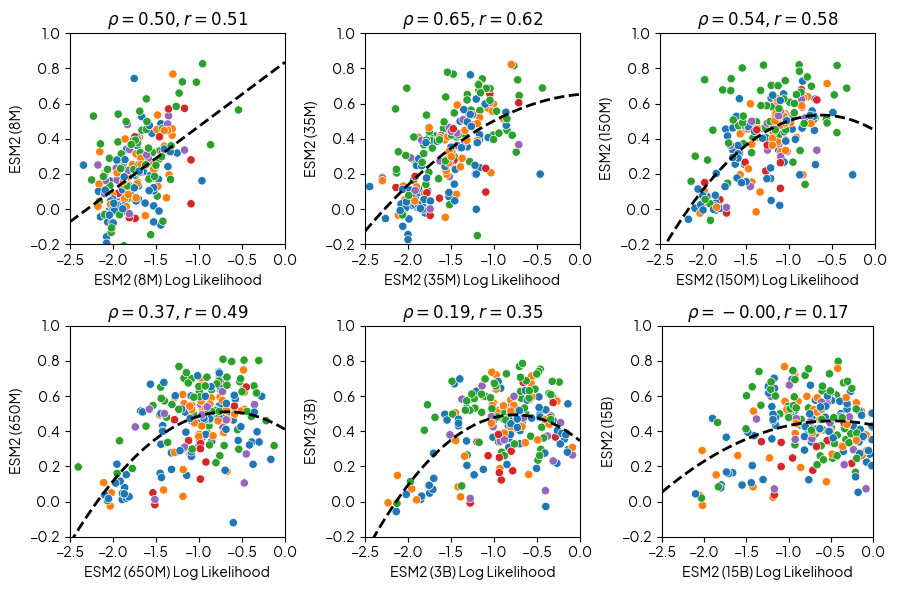

In [88]:
s = 1/2
plt.figure(figsize=(18 * s, 12 * s))
# plot all 4 models side by side
for i, col_name in enumerate(list(esm_lls.keys())[::-1]):
    plt.subplot(2, 3, i+1)
    sns.scatterplot(data=spearman_df, x=col_name, y=col_name[:col_name.find(ll_string)], hue="Selection Type")
    plt.xlim(-2.5, 0)
    plt.ylim(-0.2, 1)
    plt.ylabel(f"{col_name[:col_name.find(ll_string)]} DMS Spearman")
    plt.xlabel(col_name)
    plt.title(f"$\\rho={correlations[col_name[:col_name.find(ll_string)]][0]:.2f}, r={correlations[col_name[:col_name.find(ll_string)]][1]:.2f}$")
    # hide the legend for all but the third plot
    plt.legend().remove()
    sns.regplot(data=spearman_df, x=col_name, y=col_name[:col_name.find(')')+1],
                scatter=False, color='black', order=2, ci=None, line_kws={'lw': 2, 'ls': '--'}, truncate=False,
                label="Line of Best Fit")
plt.gca().set_box_aspect(1)

# add legend for whole figure
plt.tight_layout()
# plt.subplot(2, 3, 5)
# plt.legend(
#     title="Selection Assay", loc='center', bbox_to_anchor=(0.5, -0.35), ncol=6, frameon=False)

plt.savefig('fig2_a.svg')

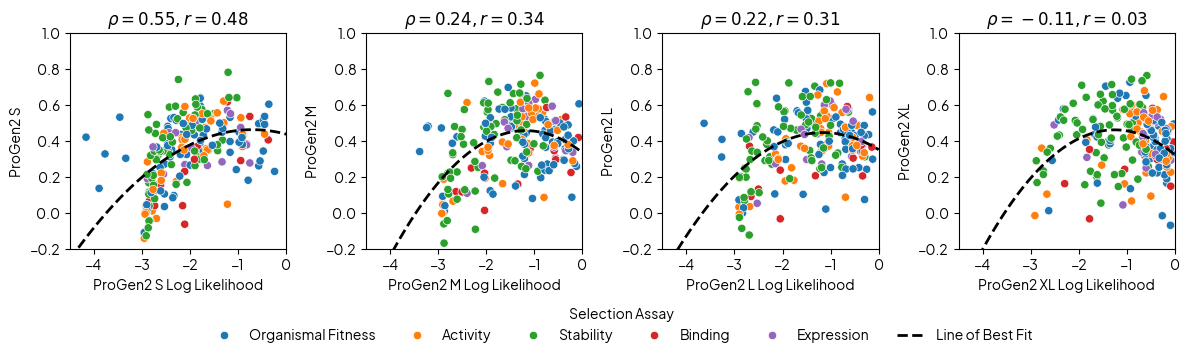

In [92]:
s = 1/2
plt.figure(figsize=(24 * s, 6 * s))
# plot all 4 models side by side
for i, col_name in enumerate(list(progen_lls.keys())):
    plt.subplot(1, 4, i+1)
    sns.scatterplot(data=spearman_df, x=col_name, y=col_name[:col_name.find(ll_string)], hue="Selection Type")
    plt.xlim(-4.5, 0)
    plt.ylim(-0.2, 1)
    plt.ylabel(f"{col_name[:col_name.find(ll_string)]} DMS Spearman")
    plt.xlabel(col_name)
    plt.title(f"$\\rho={correlations[col_name[:col_name.find(ll_string)]][0]:.2f}, r={correlations[col_name[:col_name.find(ll_string)]][1]:.2f}$")
    # plt.title(f"Spearman: {correlations[col_name[:col_name.find(ll_string)]][0]:.2f}, Pearson: {correlations[col_name[:col_name.find(ll_string)]][1]:.2f}")
    # hide the legend for all but the third plot
    plt.legend().remove()
    sns.regplot(data=spearman_df, x=col_name, y=col_name[:col_name.find(ll_string)],
                scatter=False, color='black', order=2, ci=None, line_kws={'lw': 2, 'ls': '--'}, truncate=False,
                label="Line of Best Fit")
    plt.gca().set_box_aspect(1)

# add legend for whole figure
plt.tight_layout()
plt.subplot(1, 4, 2)
plt.legend(
    title="Selection Assay", loc='center', bbox_to_anchor=(1.18, -0.35), ncol=6, frameon=False)

plt.savefig('fig2_b.svg')


In [34]:
# get average spearmans for each model and put in a dataframe
esm_model_names = [
    "ESM2 (8M)",
    "ESM2 (35M)",
    "ESM2 (150M)",
    "ESM2 (650M)",
    "ESM2 (3B)",
    "ESM2 (15B)",
]
progen_model_names = [
    "ProGen2 S",
    "ProGen2 M",
    "ProGen2 L",
    "ProGen2 XL",
]
esm_model_spearman = [spearman_df[i].mean() for i in esm_model_names]
progen_model_spearman = [spearman_df[i].mean() for i in progen_model_names]
print(esm_model_spearman)
print(progen_model_spearman)


[0.20559907834101385, 0.31882949308755765, 0.4005576036866359, 0.4382119815668203, 0.4321152073732719, 0.4252580645161291]
[0.3442119815668202, 0.39187096774193547, 0.3922764976958526, 0.40561290322580645]


In [78]:
# https://stackoverflow.com/a/7968690
def forceAspect(ax, aspect=1):
    extent = (*ax.get_xlim(), *ax.get_ylim())
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

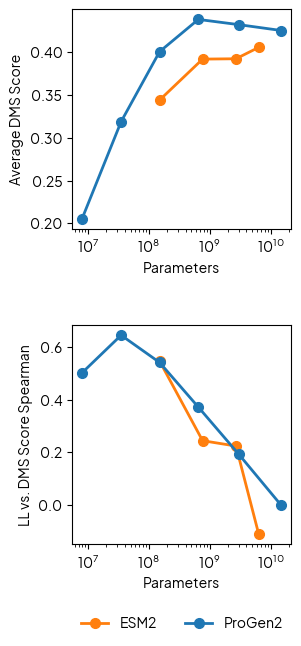

In [90]:
# plot of "meta correlation" vs param count
esm_params = [8_000_000, 35_000_000, 150_000_000, 650_000_000, 3_000_000_000, 15_000_000_000]
progen_params = [151_000_000, 764_000_000, 2_700_000_000, 6_400_000_000]
plt.figure(figsize=(3, 6))

plt.subplot(2, 1, 1)
# plt.gca().set_aspect("equal")
plt.plot(esm_params, esm_model_spearman, 'o-', label="ESM2", lw=2, markersize=7)#, color="#011FFD")
plt.plot(progen_params, progen_model_spearman, 'o-', label="ProGen2", lw=2, markersize=7)#, color="#EE6E26")
plt.xlabel("Parameters")
plt.ylabel("Average DMS Score")
plt.xscale('log')
plt.gca().set_box_aspect(1)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(progen_params, [correlations[col_name[:col_name.find(ll_string)]][0] for col_name in progen_lls], 'o-', label="ESM2", lw=2, markersize=7, color="C1")
plt.plot(esm_params[::-1], [correlations[col_name[:col_name.find(ll_string)]][0] for col_name in esm_lls], 'o-', label="ProGen2", lw=2, markersize=7, color="C0")
plt.ylabel("LL vs. DMS Score Spearman")
plt.xlabel("Parameters")
plt.xscale('log')
plt.gca().set_box_aspect(1)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=False)
plt.savefig('fig2_c.svg')

/tmp/ipykernel_2067522/3702433648.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


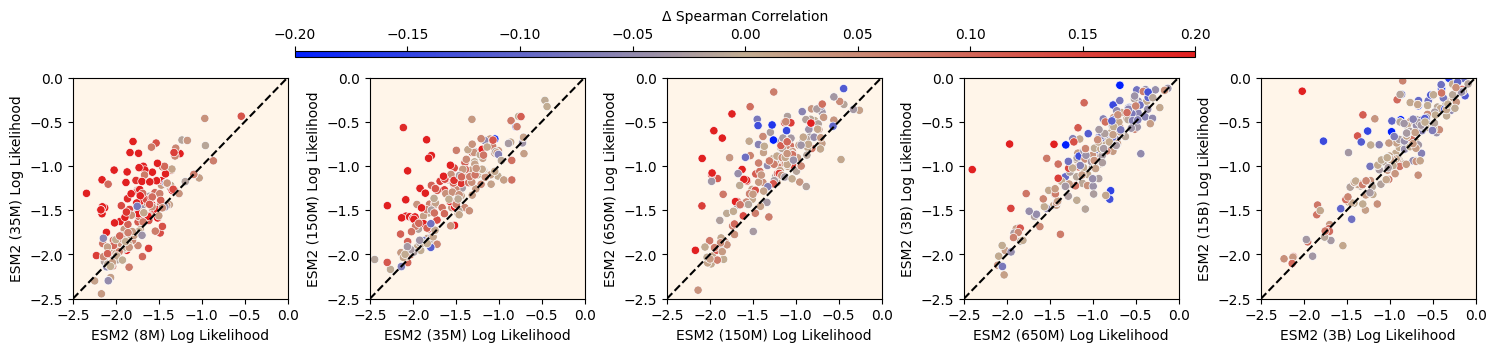

In [17]:
# make 5 plots comparing a model to it's larger counterpart
n = 3
plt.figure(figsize=(5*n, n))

diffs = [spearman_df[model_names[i+1]] - spearman_df[model_names[i]] for i in range(5)]
extreme = max([abs(i).max() for i in diffs])
extreme = 0.2

norm = plt.Normalize(-extreme, extreme)
# make color map from list of colors and not coolwarm
cmap = sns.blend_palette(["#011FFD", "#C2AD92", "#E12020"], as_cmap=True)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.gca().set_facecolor(face_color)
    x_axis = model_names[i] + " Log Likelihood"
    y_axis = model_names[i+1] + " Log Likelihood"
    plt.xlim(-2.5, 0)
    plt.ylim(-2.5, 0)
    # plot y = x line using axline
    plt.axline((0, 0), (1, 1), color='black', linestyle='--')
    sns.scatterplot(data=spearman_df, x=x_axis, y=y_axis, c=diffs[i], cmap=cmap, norm=norm)

# add a colorbar at the top of the figure
cax = plt.axes([0.2, 1, 0.6, 0.02])
cbar = plt.colorbar(sm, cax, orientation='horizontal', pad=0.2)
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.set_xlabel("Δ Spearman Correlation", labelpad=5)
cbar.ax.xaxis.set_label_position('top')
plt.tight_layout()

In [18]:
# save the spearman df
spearman_df.to_csv('spearman_df_with_ll.csv', index=False)